<a href="https://colab.research.google.com/github/Dailer/Astro/blob/master/R_igraph_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
install.packages('igraph')
require(igraph)
require(data.table)

In [110]:
kruskalmc=function(resp, data=NULL, probs=0.05, cont=NULL){
  mf=model.frame(resp,data)
  resp=mf[,1]
  categ=mf[,2]
  db=na.omit(data.frame(resp,categ))
  if(nrow(db)!=length(resp)) 
    warning(paste(length(resp)-nrow(db),"lines including NA have been omitted"))
  resp=db[,1]
  categ=db[,2]
  lst=split(rank(resp), categ)
  name=names(lst)
  R=sapply(lst, mean)
  n=sapply(lst, length)
  N=length(resp)
  dif=abs(outer(R, R, "-"))
  if(is.null(cont)) {
    difv=vname=indices=NULL
    for(i in 1:(length(name)-1)){
      for(j in (i+1):length(name)) {
        vname=c(vname, paste(name[i], "-", name[j], sep = ""))
        indices=rbind(indices, c(i, j))
        difv=c(difv,dif[i,j])
      }
    }
    names(difv)=vname
    z=qnorm(probs/(length(lst)*(length(lst)-1)), lower.tail=F)
    lims=z*sqrt((N*(N+1)/12)*(1/n[indices[1:length(vname),1]]+1/n[indices[1:length(vname),2]]))
    names(lims)=vname
    stat="Multiple comparison test after Kruskal-Wallis"
  }else{
    vname=indices=NULL
    for(j in 2:length(dif[1, ])){
      vname=c(vname, paste(name[1], "-", name[j], sep = ""))
      indices=rbind(indices, c(1, j))
    }
    dif=dif[1, 2:length(dif[1, ])]
    names(dif)=vname
    difv=dif
    choice=pmatch(cont, c("two-tailed","one-tailed"), nomatch=3)
    if(choice==1) {
      z=qnorm(probs/(2*(length(lst)-1)), lower.tail=F)
      lims=z*sqrt((N*(N + 1))/12*(1/n[indices[1:length(vname), 1]]
                                  +1/n[indices[1:length(vname), 2]]))
      names(lims)=vname
      stat="Multiple comparison test after Kruskal-Wallis, treatments vs control (two-tailed)"
    }
    if(choice==2){
      z=qnorm(probs/(length(lst)-1), lower.tail=F)
      lims=z*sqrt((N*(N+1)/12)*(1/n[indices[1:length(vname), 1]]
                                +1/n[indices[1:length(vname), 2]]))
      names(lims)=vname
      stat="Multiple comparison test after Kruskal-Wallis, treatment vs control (one-tailed)"
    }
    if(choice==3) 
      stop("Values must be 'one-tailed' or 'two-tailed', partial matching accepted")
  }
  output=list(statistic=stat, signif.level=probs, 
              dif.com=data.frame(obs.dif=difv, critical.dif=lims, 
                                 difference=ifelse((difv-lims)>0, TRUE, FALSE)))
  class(output)=c("mc", "list")
  output
}

kw=function(data, class, probs=0.05){
  n=ncol(data)
  k=vector('list', length = n)
  for(i in 1:n){
    k[[i]]=kruskalmc(unlist(data[,..i])~class, probs=probs)$dif.com
  }
  rn=rownames(k[[1]])
  cn=colnames(data)
  kl=lapply(k, function(x) x[,3])
  ku=data.table(rn, do.call(cbind, kl))
  colnames(ku)=c('comp', cn)
  return(ku)
}

graph_info=function(data, plot=T){
  comp=data$comp
  x=unlist(data[,2])
  s=comp[!x]
  df=as.data.frame(do.call(rbind,strsplit(s, '-')))
  g=graph_from_data_frame(df, directed = F)
  if(plot) plot(g)
  #nc=components(g)$no
  eb=cluster_edge_betweenness(g)
  nc=length(unique(eb$membership))
  return(nc)
}

gcew=function(data, plot=F){
  comp=data$comp
  x=unlist(data[,2])
  s=comp[!x]
  df=as.data.frame(do.call(rbind,strsplit(s, '-')))
  g=graph_from_data_frame(df, directed = F)
  if(plot) plot(g)
  eb=cluster_edge_betweenness(g)
  mem=eb$membership
  cl=1:length(mem)
  dd=data.frame(cl=cl, deg=degree(g))
  d=data.frame(cl=cl, mem=mem)
  d=merge(d, dd, by='cl', all.x=T)
  return(d)
}

In [6]:
unzip('yang_cl_caust.zip')
y=fread('yang_cl_caust.dat')
y=y[N200>=10]
y=y[Rp<=3 & absu<=3]
hc=hclust(dist(y[,.(Rp,absu)]))
cnames=c('urcolor','grcolor','color_grad','conx','TType','nb','ng','BTr.1','smass','sfr','ssfr','d4000n')

In [9]:
m=matrix(NA, 98, 12)
p=vector(length = 12)
pb=txtProgressBar(3,100,0,'=',style=3)
for(i in 3:100){
  hs=cutree(hc, k=i)
  #plot(y$Rp, y$absu, pch=20, cex=.5, col=hs)
  #points(y$Rp[hs==21], y$absu[hs==21], pch=4)
  kr=kw(y[,..cnames],hs)
  for(j in 2:13){
    cc=c(1,j)
    p[j-1]=graph_info(kr[,..cc], plot = F)
  }
  m[i-2,]=p
  setTxtProgressBar(pb, i)
}

  |======================================================================| 100%

In [14]:
colnames(m)=cnames
m=data.table(m)
saveRDS(data.table(m), 'm.RDS')
print(m)
m=m[,-c('nb','ng','smass','color_grad','conx','grcolor','BTr.1')]

In [74]:
n=apply(m, 1, sum)
#barplot(n, names.arg = 3:100)
which(n==max(n))

[1] 60 61

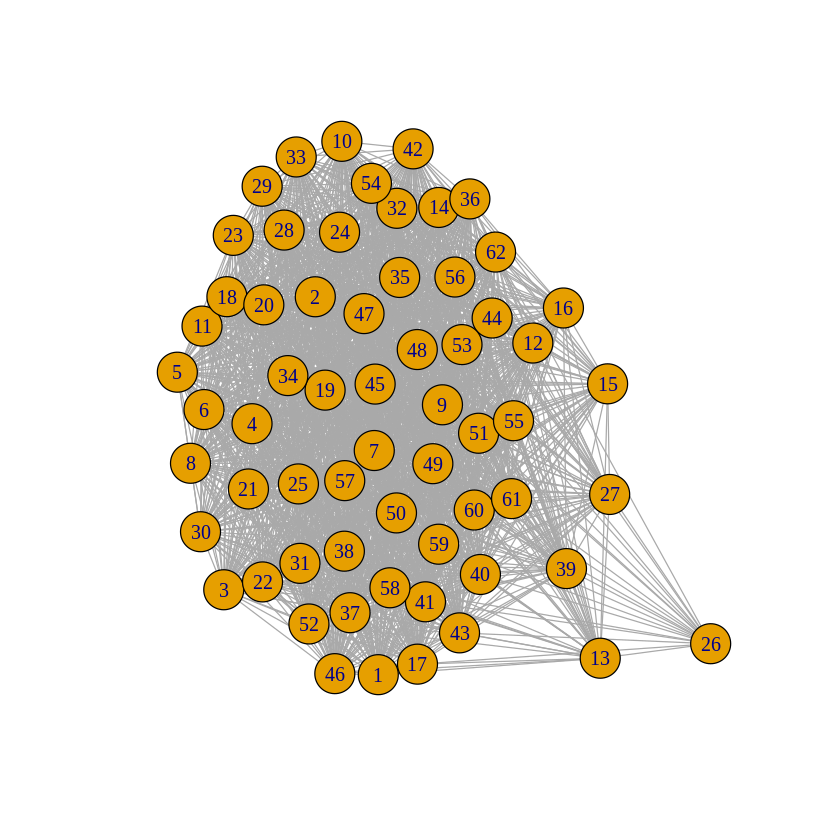

In [111]:
k=62
hs=cutree(hc, k=k)
#plot(y$Rp, y$absu, pch=20, cex=.5, col=hs)
plot(y$Rp, y$absu, pch='')

pchs=c(16, 0, 17, 3, 15, 4, 1, 8, 2, 7, 5, 9, 6, 10, 11, 18, 12, 13, 14)
colors=c("dodgerblue2", "red3", "green3", "slateblue", "darkorange", "skyblue1", "violetred4", "forestgreen",
         "steelblue4", "slategrey", "brown", "black", "darkseagreen", "darkgoldenrod3", "olivedrab", "royalblue", 
         "tomato4", "cyan2", "springgreen2")

var='ssfr'
kr=kw(y[,..var],hs)
cl=gcew(kr, plot=T)
q=unique(cl$mem)
for(i in q){
  cls=cl$cl[cl$mem==i]
  points(y$Rp[hs %in% cls], y$absu[hs %in% cls], pch=pchs[i], col=colors[i])
}
title(var)
mtext(paste('k =',k))

In [112]:
cl

cl,mem,deg
<int>,<dbl>,<dbl>
1,1,60
2,1,58
3,1,54
4,1,55
5,1,54
6,1,54
7,1,59
8,1,55
9,1,61


In [91]:
round(eb$modularity,4)

[1] -0.0164 -0.0165 -0.0166 -0.0167 -0.0169 -0.0172 -0.0175 -0.0178 -0.0182
[10] -0.0187 -0.0186 -0.0191 -0.0196 -0.0201 -0.0208 -0.0213 -0.0218 -0.0224
[19] -0.0232 -0.0231 -0.0237 -0.0246 -0.0249 -0.0246 -0.0256 -0.0263 -0.0260
[28] -0.0257 -0.0242 -0.0237 -0.0226 -0.0220 -0.0213 -0.0216 -0.0195 -0.0187
[37] -0.0179 -0.0166 -0.0164 -0.0142 -0.0147 -0.0132 -0.0121 -0.0130 -0.0105
[46] -0.0092 -0.0065 -0.0037 -0.0018 -0.0022 -0.0027 -0.0022  0.0007  0.0038
[55]  0.0031  0.0025  0.0019  0.0012  0.0002  0.0002 -0.0001  0.0000

In [ ]:
head(cl)

In [70]:
zip_inst_lib=function(){
  file.copy('/usr/local/lib/R/site-library', '/content', recursive=T)
  # folders to remove
  ftr=c('IRdisplay','IRkernel','pbdZMQ','repr')
  l=lapply(ftr, function(x) unlink(paste0('/content/site-library/',x), recursive=T))
  zip('/content/site-library.zip', '/content/site-library')
  unlink('/content/site-library/', recursive=T)
}

In [71]:
zip_inst_lib()